# 1. 환경준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [2]:
path = 'https://raw.githubusercontent.com/jangrae/csv/master/titanic.csv'
data = pd.read_csv(path)

# 2. 데이터 이해

In [3]:
data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [5]:
data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [6]:
# 결측치를 어떻게 처리할지 고민.

data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# 3. 데이터 준비

#### 1) Title 변수 추가

In [7]:
data['Title'] = data['Name'].str.extract('([A-Za-z]+)\.', expand=False)

# 이름의 Mr, Miss, Mrs 등을 따로 관리

In [8]:
main_tit_list = ['Mr', 'Miss', 'Mrs']
data.loc[data['Title'].isin(main_tit_list)==False, ['Title']] = 'Others'

# Mr, Miss, Mrs 이외의 성은 Others 로 표현

#### 2) 결측치 처리

In [9]:
data['Age'].fillna(data.groupby('Title')['Age'].transform('median'), inplace=True)

# 나이 결측치를 같은 성을 가진 사람의 중앙값으로 채운다.

In [10]:
data['Embarked'].fillna('S', inplace=True)

# Embarked 는 최빈치인 S 로 채운다.

#### 3) AgeGroup 변수 추가

In [11]:
data['AgeGroup'] = pd.cut(data['Age'], 
                          bins=[0, 16, 25, 35, 60, 100], 
                          labels=['0_16', '17_25', '26_35', '36_60', '61_100'])

# 나이대별 변수를 추가해준다.

#### 4) 가변수화

In [12]:
dummy_vars = ['Title', 'AgeGroup', 'Pclass', 'Sex', 'Embarked']
data = pd.get_dummies(data, columns=dummy_vars, drop_first=True)

# 가변수화를 해주어야 문자를 나눠서 분석에 쓸 수 있다.

#### 5) 불필요한 변수 제거

In [13]:
drop_cols = ['PassengerId', 'Name', 'Age', 'Ticket', 'Cabin']
data.drop(drop_cols, axis=1, inplace=True)

# 확인
data.head()

,Survived,SibSp,Parch,Fare,Title_Mr,Title_Mrs,Title_Others,AgeGroup_17_25,AgeGroup_26_35,AgeGroup_36_60,AgeGroup_61_100,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,0,1,0,7.2500,1,0,0,1,0,0,0,0,1,1,0,1
1,1,1,0,71.2833,0,1,0,0,0,1,0,0,0,0,0,0
2,1,0,0,7.9250,0,0,0,0,1,0,0,0,1,0,0,1
3,1,1,0,53.1000,0,1,0,0,1,0,0,0,0,0,0,1
4,0,0,0,8.0500,1,0,0,0,1,0,0,0,1,1,0,1


#### 6) x,y 분리

In [14]:
target = 'Survived'

x = data.drop(target, axis=1)
y = data[target]

#### 7) 정규화

In [15]:
x = (x-x.min()) / (x.max()-x.min())
x.head(3)

# 변수마다 숫자 의미가 다르기때문에 비율적으로 동일시 해준다.
# KNN 은 정규화 하는 것이 효율적인 모델화

,SibSp,Parch,Fare,Title_Mr,Title_Mrs,Title_Others,AgeGroup_17_25,AgeGroup_26_35,AgeGroup_36_60,AgeGroup_61_100,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,0.125,0.0,0.014151,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,0.125,0.0,0.139136,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000,0.0,0.015469,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


#### 8) train,test 분리

In [16]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,
                                                 random_state=2022)

# 4. 모델링

In [26]:
# 1단계 : 불러오기
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

#### k값을 지정해줄 수 있음
- k는 홀수로 -> 짝수이면 동일한 분류가 되어 애매한 상황이 오기도 함.
- k는 1이 될 수 없음

In [27]:
# 2단계 : 선언하기
model = KNeighborsClassifier(n_neighbors=7)

In [28]:
# 3단계 : 학습하기
model.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=7)

In [29]:
# 4단계 : 예측하기
y_pred = model.predict(x_test)

In [30]:
# 5단계 : 평가하기
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[153  15]
 [ 37  63]]
              precision    recall  f1-score   support

           0       0.81      0.91      0.85       168
           1       0.81      0.63      0.71       100

    accuracy                           0.81       268
   macro avg       0.81      0.77      0.78       268
weighted avg       0.81      0.81      0.80       268



#### for문을 통해 정확도 결과를 표현할 수 있음

In [36]:
result=[]

for i in range(3,51,2):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    result.append(accuracy_score(y_test,y_pred))
    
print(result)

[0.7910447761194029, 0.8134328358208955, 0.8059701492537313, 0.7985074626865671, 0.8208955223880597, 0.8022388059701493, 0.8171641791044776, 0.8208955223880597, 0.8022388059701493, 0.8059701492537313, 0.7947761194029851, 0.8097014925373134, 0.8097014925373134, 0.8022388059701493, 0.7835820895522388, 0.7761194029850746, 0.7723880597014925, 0.7910447761194029, 0.7910447761194029, 0.8022388059701493, 0.8059701492537313, 0.8097014925373134, 0.8022388059701493, 0.8022388059701493]


0.8208955223880597


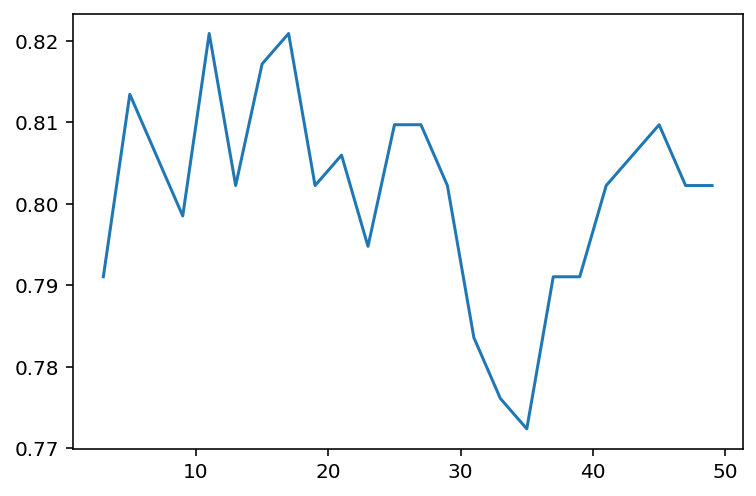

In [37]:
print(max(result))
plt.plot(list(range(3,51,2)), result)


plt.show()

#### k=17일 때, 설명력이 가장 높다.